In [ ]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
import numpy
from galpy.util import bovy_plot
%pylab inline
from matplotlib import cm
numpy.random.seed(4)
import copy
import matplotlib.animation as animation
from IPython.display import HTML
import seaborn as sns
from hom2m_sc1d import *

Populating the interactive namespace from numpy and matplotlib


# Harmonic-oscillator M2M

## Mock observations

We sample from a distribution $f(z,v_z) \propto e^{-E/\sigma^2}$ with $\sigma = 0.1$. The gravitational potential is $\Phi(z) = \omega^2 z^2 / 2$, with $\omega = 1.3$. Sampling from $f(z,v_z)$ can be simply done by sampling $E \leftarrow e^{-E/\sigma^2}$ and $\phi \leftarrow \mathrm{Uniform(0,2\pi)}$ and then computing $z = \sqrt{2E}/\omega\,\cos\phi,\ v_z = -\sqrt{2E}\, \sin(\phi)$.

In [3]:
n_mock= 10000
sigma_true= 0.1
omega_true= 1.3
E_mock= numpy.random.exponential(scale=sigma_true**2.,size=n_mock)
phi_mock= numpy.random.uniform(size=n_mock)*2.*numpy.pi
z_mock= numpy.sqrt(2.*E_mock)/omega_true*numpy.cos(phi_mock)
vz_mock= -numpy.sqrt(2.*E_mock)*numpy.sin(phi_mock)

The density distribution is Gaussian as expected:

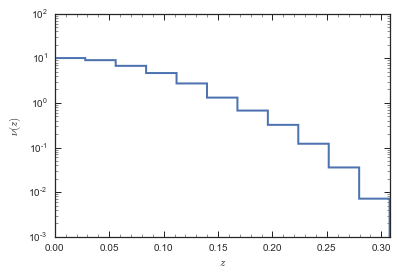

In [4]:
_= bovy_plot.bovy_hist(numpy.fabs(z_mock),bins=11,normed=True,
                       xlabel=r'$z$',ylabel=r'$\nu(z)$',lw=2.,histtype='step')
gca().set_yscale('log')

Now we 'observe' this density distribution from $z_{\mathrm{sun}} = 0.05$:

In [5]:
zsun_true= 0.05

# We only observe the density at a few z
z_obs= numpy.array([0.1,0.15,0.2,-0.1,-0.15,-0.2])
h_obs= 0.1
dens_obs= compute_dens(z_mock,zsun_true,z_obs,h_obs)
dens_obs_noise= numpy.sqrt(dens_obs)*0.2*numpy.sqrt(numpy.amax(dens_obs))\
    /(numpy.fabs(z_obs**2)/numpy.amin(numpy.fabs(z_obs**2)))
dens_obs+= numpy.random.normal(size=dens_obs.shape)*dens_obs_noise

The observed density is:

<Container object of 3 artists>

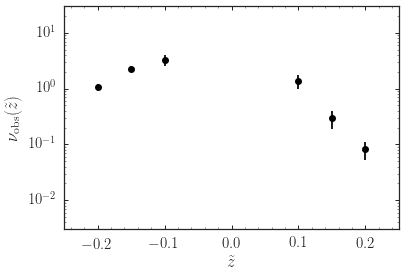

In [6]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(6,4)
bovy_plot.bovy_plot(z_obs,dens_obs,'ko',semilogy=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[-.25,0.25],yrange=[0.003,30.])
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color='k')

## Basic M2M fit

Here we perform the basic M2M fit to the observed density assuming we know the potential.

The initial density profile (blue line) is very different from the target:

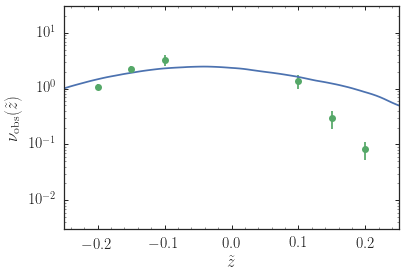

In [14]:
n_m2m= 1000
sigma_init= 0.2
E_m2m= numpy.random.exponential(scale=sigma_init**2.,size=n_m2m)
phi_m2m= numpy.random.uniform(size=n_m2m)*2.*numpy.pi
A_m2m= numpy.sqrt(2.*E_m2m)/omega_true
w_init= numpy.ones(n_m2m)
z_m2m= A_m2m*numpy.cos(phi_m2m)
z_out= numpy.linspace(-0.3,0.3,101)
dens_init= compute_dens(z_m2m,zsun_true,z_out,h_obs,w_init)
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(6,4)
bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[-.25,0.25],yrange=[0.003,30.])
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
yscale('log',nonposy='clip')

Run without any smoothing:

In [15]:
step= numpy.pi/3.*10.**-2.
nstep= 30000
eps= 10.**-2.
mu= 10.
h_m2m= h_obs
omega_m2m= omega_true
zsun_m2m= zsun_true
w_out,Q,wevol,windx= run_m2m_weights(w_init,A_m2m,phi_m2m,omega_m2m,zsun_m2m,
                                     z_obs,dens_obs,dens_obs_noise,
                                     nstep=nstep,step=step,mu=mu,eps=eps,h_m2m=h_m2m,
                                     output_wevolution=10)

('Velocity dispersions: mock, fit', 0.099971170801918099, 0.12129469375192144)


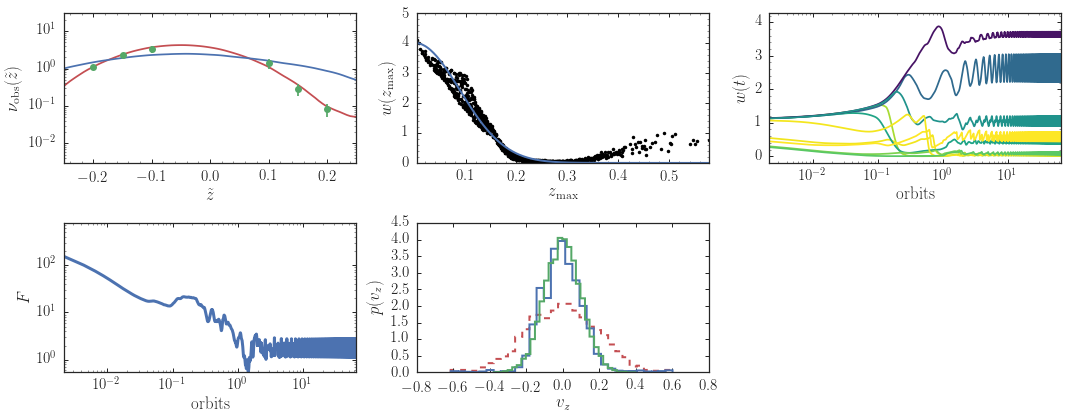

In [16]:
z_m2m= A_m2m*numpy.cos(phi_m2m+nstep*step*omega_m2m)
vz_m2m= -A_m2m*omega_m2m*numpy.sin(phi_m2m+nstep*step*omega_m2m)
z_out= numpy.linspace(-0.3,0.3,101)
dens_final= compute_dens(z_m2m,zsun_true,z_out,h_obs,w_out)
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(15,6)
subplot(2,3,1)
bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[-.25,0.25],yrange=[0.003,30.],gcf=True)
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True)
bovy_plot.bovy_plot(z_out,dens_final,'-',semilogy=True,overplot=True,zorder=0)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
yscale('log',nonposy='clip')
subplot(2,3,2)
bovy_plot.bovy_plot(A_m2m,w_out,'k.',xlabel=r'$z_{\mathrm{max}}$',ylabel=r'$w(z_{\mathrm{max}})$',
                   yrange=[0.,5.],gcf=True)
sindx= numpy.argsort(A_m2m)
w_expect= numpy.exp((A_m2m[sindx]*omega_m2m)**2./2.*(1./sigma_init**2.-1./sigma_true**2.))
w_expect/= numpy.sum(w_expect)/len(w_expect)
plot(A_m2m[sindx],w_expect,lw=2.)
subplot(2,3,3)
for ii in range(len(wevol)):
    bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*omega_true/2./numpy.pi,wevol[ii],'-',
                        color=cm.viridis(A_m2m[windx][ii]/0.3),
                        yrange=[-0.2,numpy.amax(wevol)*1.1],
                        semilogx=True,xlabel=r'$\mathrm{orbits}$',ylabel=r'$w(t)$',gcf=True,overplot=ii>0)
subplot(2,3,4)
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*omega_true/2./numpy.pi,numpy.sum(Q,axis=1),lw=3.,
                   loglog=True,xlabel=r'$\mathrm{orbits}$',ylabel=r'$F$',gcf=True)
subplot(2,3,5)
_= hist(vz_m2m,weights=w_out,histtype='step',lw=2.,normed=True,bins=31,zorder=1)
_= hist(vz_mock,histtype='step',lw=2.,normed=True,bins=31,zorder=2)
_= hist(vz_m2m,histtype='step',lw=2.,normed=True,bins=31,ls='--',zorder=0)
xlabel(r'$v_z$')
ylabel(r'$p(v_z)$')
print("Velocity dispersions: mock, fit",numpy.std(vz_mock),\
      numpy.sqrt(numpy.sum(w_out*(vz_m2m-numpy.sum(w_out*vz_m2m)/numpy.sum(w_out))**2.)/numpy.sum(w_out)))
tight_layout()

Run with smoothing:

In [9]:
step= numpy.pi/3.*10.**-2.
nstep= 30000
eps= 10.**-2.
mu= 10.
h_m2m= h_obs
smooth= 10.*10.**-1.
omega_m2m= omega_true
zsun_m2m= zsun_true
w_out,Q,wevol,windx= run_m2m_weights(w_init,A_m2m,phi_m2m,omega_m2m,zsun_m2m,
                                     z_obs,dens_obs,dens_obs_noise,
                                     nstep=nstep,step=step,mu=mu,eps=eps,smooth=smooth,h_m2m=h_m2m,
                                     output_wevolution=10)

('Velocity dispersions: mock, fit', 0.099971170801918099, 0.1339877699953344)


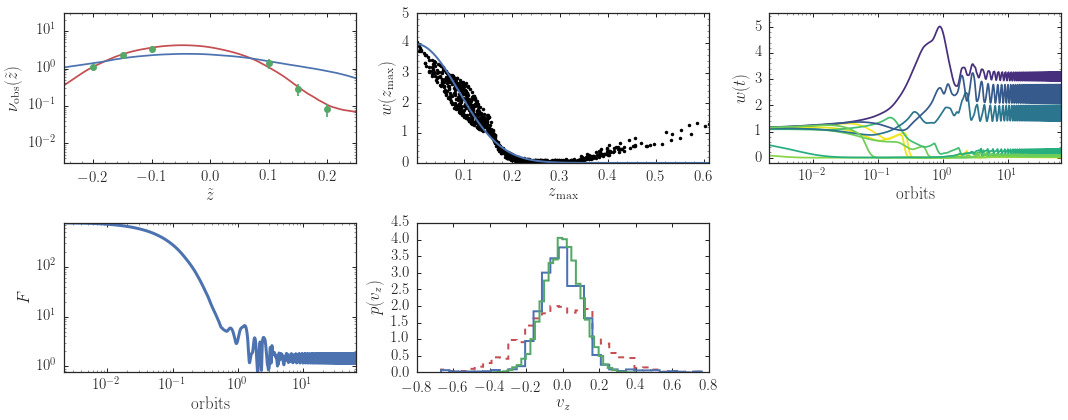

In [10]:
z_m2m= A_m2m*numpy.cos(phi_m2m+nstep*step*omega_m2m)
vz_m2m= -A_m2m*omega_m2m*numpy.sin(phi_m2m+nstep*step*omega_m2m)
z_out= numpy.linspace(-0.3,0.3,101)
dens_final= compute_dens(z_m2m,zsun_true,z_out,h_obs,w_out)
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(15,6)
subplot(2,3,1)
bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[-.25,0.25],yrange=[0.003,30.],gcf=True)
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True)
bovy_plot.bovy_plot(z_out,dens_final,'-',semilogy=True,overplot=True,zorder=0)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
yscale('log',nonposy='clip')
subplot(2,3,2)
bovy_plot.bovy_plot(A_m2m,w_out,'k.',xlabel=r'$z_{\mathrm{max}}$',ylabel=r'$w(z_{\mathrm{max}})$',
                   yrange=[0.,5.],gcf=True)
sindx= numpy.argsort(A_m2m)
w_expect= numpy.exp((A_m2m[sindx]*omega_m2m)**2./2.*(1./sigma_init**2.-1./sigma_true**2.))
w_expect/= numpy.sum(w_expect)/len(w_expect)
plot(A_m2m[sindx],w_expect,lw=2.)
subplot(2,3,3)
for ii in range(len(wevol)):
    bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*omega_true/2./numpy.pi,wevol[ii],'-',
                        color=cm.viridis(A_m2m[windx][ii]/0.3),
                        yrange=[-0.2,numpy.amax(wevol)*1.1],
                        semilogx=True,xlabel=r'$\mathrm{orbits}$',ylabel=r'$w(t)$',gcf=True,overplot=ii>0)
subplot(2,3,4)
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*omega_true/2./numpy.pi,numpy.sum(Q,axis=1),lw=3.,
                   loglog=True,xlabel=r'$\mathrm{orbits}$',ylabel=r'$F$',gcf=True)
subplot(2,3,5)
_= hist(vz_m2m,weights=w_out,histtype='step',lw=2.,normed=True,bins=31,zorder=1)
_= hist(vz_mock,histtype='step',lw=2.,normed=True,bins=31,zorder=2)
_= hist(vz_m2m,histtype='step',lw=2.,normed=True,bins=31,ls='--',zorder=0)
xlabel(r'$v_z$')
ylabel(r'$p(v_z)$')
print("Velocity dispersions: mock, fit",numpy.std(vz_mock),\
      numpy.sqrt(numpy.sum(w_out*(vz_m2m-numpy.sum(w_out*vz_m2m)/numpy.sum(w_out))**2.)/numpy.sum(w_out)))
tight_layout()

## Also vary $z_\odot$ during the optimization

We write down the force of change for $z_\odot$ and also fit for it:

In [11]:
step= numpy.pi/3.*10.**-2.
nstep= 10000
eps= 0.01
eps_zo= eps/500.
mu= 10.0
h_m2m= h_obs
omega_m2m= omega_true
zsun_m2m= zsun_true-0.05
(w_out,zsun_out),Q,wevol,windx= run_m2m_weights_zsun(w_init,A_m2m,phi_m2m,omega_m2m,zsun_m2m,
                                                     z_obs,dens_obs,dens_obs_noise,
                                                     nstep=nstep,step=step,mu=mu,eps=eps,h_m2m=h_m2m,
                                                     eps_zo=eps_zo,output_wevolution=10)

('Velocity dispersions: mock, fit', 0.099971170801918099, 0.12570064833658434)
('Zsun: fit, starting point', 0.047248263534394611, 0.0)


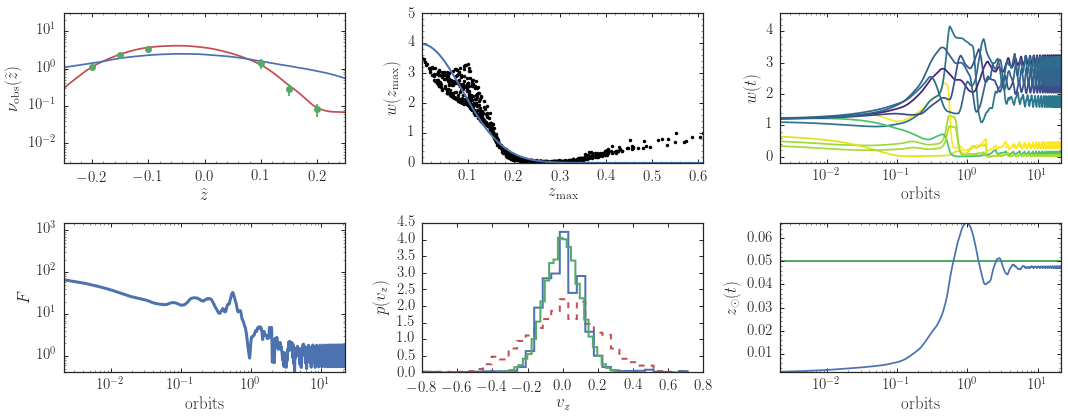

In [12]:
z_m2m= A_m2m*numpy.cos(phi_m2m+nstep*step*omega_m2m)
vz_m2m= -A_m2m*omega_m2m*numpy.sin(phi_m2m+nstep*step*omega_m2m)
z_out= numpy.linspace(-0.3,0.3,101)
dens_final= compute_dens(z_m2m,zsun_out[-1],z_out,h_obs,w_out)
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(15,6)
subplot(2,3,1)
bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[-.25,0.25],yrange=[0.003,30.],gcf=True)
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True)
bovy_plot.bovy_plot(z_out,dens_final,'-',semilogy=True,overplot=True,zorder=0)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
yscale('log',nonposy='clip')
subplot(2,3,2)
bovy_plot.bovy_plot(A_m2m,w_out,'k.',xlabel=r'$z_{\mathrm{max}}$',ylabel=r'$w(z_{\mathrm{max}})$',
                   yrange=[0.,5.],gcf=True)
sindx= numpy.argsort(A_m2m)
w_expect= numpy.exp((A_m2m[sindx]*omega_m2m)**2./2.*(1./sigma_init**2.-1./sigma_true**2.))
w_expect/= numpy.sum(w_expect)/len(w_expect)
plot(A_m2m[sindx],w_expect,lw=2.)
subplot(2,3,3)
for ii in range(len(wevol)):
    bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*omega_true/2./numpy.pi,wevol[ii],'-',
                        color=cm.viridis(A_m2m[windx][ii]/0.3),
                        yrange=[-0.2,numpy.amax(wevol)*1.1],
                        semilogx=True,xlabel=r'$\mathrm{orbits}$',ylabel=r'$w(t)$',gcf=True,overplot=ii>0)
subplot(2,3,4)
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*omega_m2m/2./numpy.pi,numpy.sum(Q,axis=1),lw=3.,
                   loglog=True,xlabel=r'$\mathrm{orbits}$',ylabel=r'$F$',gcf=True)
subplot(2,3,5)
_= hist(vz_m2m,weights=w_out,histtype='step',lw=2.,normed=True,bins=31,zorder=1)
_= hist(vz_mock,histtype='step',lw=2.,normed=True,bins=31,zorder=2)
_= hist(vz_m2m,histtype='step',lw=2.,normed=True,bins=31,ls='--',zorder=0)
xlabel(r'$v_z$')
ylabel(r'$p(v_z)$')
subplot(2,3,6)
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*omega_m2m/2./numpy.pi,zsun_out,'-',
                   xlabel=r'$\mathrm{orbits}$',ylabel=r'$z_\odot(t)$',gcf=True,semilogx=True,zorder=1)
axhline(zsun_true,color=sns.color_palette()[1],lw=2.,zorder=0)
print("Velocity dispersions: mock, fit",numpy.std(vz_mock),\
      numpy.sqrt(numpy.sum(w_out*(vz_m2m-numpy.sum(w_out*vz_m2m)/numpy.sum(w_out))**2.)/numpy.sum(w_out)))
tight_layout()
print("Zsun: fit, starting point",zsun_out[-1],zsun_m2m)

Let's compare this to doing the basic M2M fit for different values of $z_\odot$

In [13]:
zsuns= numpy.linspace(0.0,0.1,11)
step= numpy.pi/3.*10.**-2.
nstep= 30000
eps= 10.**-2.
mu= 10.
h_m2m= h_obs
omega_m2m= omega_true
Qs= numpy.zeros_like(zsuns)
for ii,zsun_m2m in enumerate(zsuns):
    w_out,Q= run_m2m_weights(w_init,A_m2m,phi_m2m,omega_m2m,zsun_m2m,
                             z_obs,dens_obs,dens_obs_noise,nstep=nstep,step=step,mu=mu,eps=eps,h_m2m=h_m2m)
    Qs[ii]= numpy.sum(numpy.median(Q[-100:-1],axis=0))

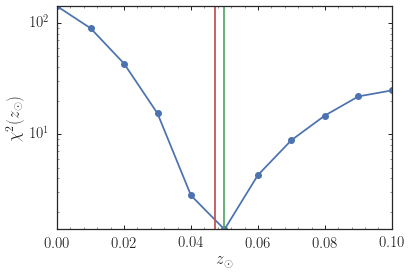

In [14]:
figsize(6,4)
bovy_plot.bovy_plot(zsuns,Qs,'o-',semilogy=True,
                   xlabel=r'$z_\odot$',ylabel=r'$\chi^2(z_\odot)$')
axvline(zsun_true,color=sns.color_palette()[1])
axvline(zsun_out[-1],color=sns.color_palette()[2])

What's the answer when we fit a simple isothermal DF?

In [21]:
def lnL_df(p,z_obs,dens_obs,dens_obs_noise):
    """p=[zsun,sigma]"""
    return -0.5*numpy.sum((numpy.exp(-0.5*(z_obs+p[0])**2.*omega_true**2./p[1]**2.)*omega_true/p[1]/numpy.sqrt(2.*numpy.pi)
                                       -dens_obs)**2./dens_obs_noise**2.)
sigmas= numpy.linspace(0.05,0.12,201)
zsuns= numpy.linspace(0.0,0.1,201)
lnL= numpy.zeros((len(zsuns),len(sigmas)))
for ii,zsun in enumerate(zsuns):
    for jj,sigma in enumerate(sigmas):
        lnL[ii,jj]= lnL_df([zsun,sigma],z_obs,dens_obs,dens_obs_noise)

/Users/dkawata/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/axes/_base.py:1215: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if aspect == 'normal':

/Users/dkawata/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/axes/_base.py:1220: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif aspect in ('equal', 'auto'):

Best fit: (zsun,sigma) = (0.050,0.115)


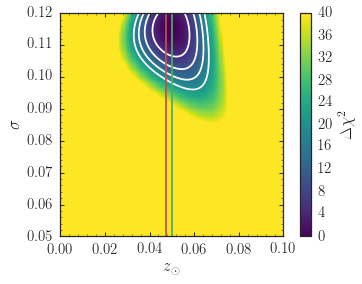

In [22]:
bovy_plot.bovy_dens2d(-2.*(lnL-numpy.amax(lnL)).T,origin='lower',
                      xrange=[zsuns[0],zsuns[-1]],
                      yrange=[sigmas[0],sigmas[-1]],
                      xlabel=r'$z_\odot$',ylabel=r'$\sigma$',
                      zlabel=r'$\Delta\chi^2$',
                      colorbar=True,cmap='viridis',vmax=40.,
                      contours=True,levels=numpy.arange(5)*5.,cntrcolors='w',
                      interpolation='nearest')
axvline(zsun_true,color=sns.color_palette()[1])
axvline(zsun_out[-1],color=sns.color_palette()[2])
print("Best fit: (zsun,sigma) = (%.3f,%.3f)"\
          %(zsuns[numpy.unravel_index(numpy.argmax(lnL),(len(zsuns),len(sigmas)))[0]],
            sigmas[numpy.unravel_index(numpy.argmax(lnL),(len(zsuns),len(sigmas)))[1]]))

Thus, the M2M optimization finds the correct value.

## Also fit some velocity data

To prepare for trying to recover the gravitational potential at the same time as the weights, we add velocity information and fit this as well in the forces of change. The velocity data that we fit is the mean squared velocity; we generate these data from the mock data set above:

In [17]:
v2m_obs= compute_v2m(z_mock,vz_mock,zsun_true,z_obs,h_obs)
def compute_nsbin(z,zsun,z_obs,h_obs,w=None):
    if w is None: w= numpy.ones_like(z)
    nsbin= numpy.zeros_like(z_obs)
    for jj,zo in enumerate(z_obs):
       nsbin[jj]+= numpy.sum(w[numpy.fabs(zo-z+zsun)<0.05*h_obs])
    return nsbin
nsbin_obs=compute_nsbin(z_mock,zsun_true,z_obs,h_obs)
print ' Ns bin=',nsbin_obs
v2m_obs_noise= v2m_obs/numpy.sqrt(nsbin_obs)
print ' v^2 errors=',v2m_obs_noise
v2m_obs+= numpy.random.normal(size=v2m_obs.shape)*v2m_obs_noise

z_m2m= A_m2m*numpy.cos(phi_m2m)
vz_m2m= -omega_true*A_m2m*numpy.sin(phi_m2m)
v2m_init= compute_v2m(z_m2m,vz_m2m,zsun_true,z_out,h_obs,w_init)

 Ns bin= [  67.   23.    5.  414.  234.   78.]
 v^2 errors= [ 0.00129943  0.00218054  0.00401225  0.00049537  0.00066408  0.0011059 ]


Observables are now:

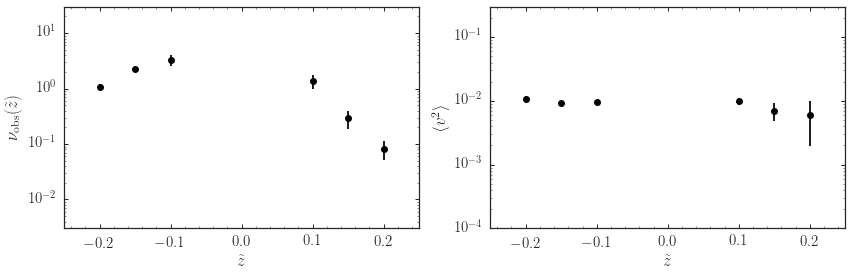

In [18]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(12,4)
subplot(1,2,1)
bovy_plot.bovy_plot(z_obs,dens_obs,'ko',semilogy=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[-.25,0.25],yrange=[0.003,30.],gcf=True)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color='k')
subplot(1,2,2)
bovy_plot.bovy_plot(z_obs,v2m_obs,'ko',semilogy=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\langle v^2\rangle$',
                   xrange=[-.25,0.25],yrange=[0.0001,.3],gcf=True)
errorbar(z_obs,v2m_obs,yerr=v2m_obs_noise,marker='None',ls='none',color='k')
tight_layout()

$<v^2>$ is constant with sigma_true=0.1$^2$, as it is set up. Let's include these observables in the force of change for the weights.

Run only with velocity constraint.

In [19]:
step= numpy.pi/3.*10.**-2.
nstep= 30000
eps= 10.**-3.
eps_vel= eps/1.
mu= 10.
h_m2m= h_obs
nodens= True
omega_m2m= omega_true
zsun_m2m= zsun_true
z_out= numpy.linspace(-0.3,0.3,101)
w_out,Q,wevol,windx= run_m2m_weights_wv2m(w_init,A_m2m,phi_m2m,omega_m2m,zsun_m2m,
                                         z_obs,dens_obs,dens_obs_noise,v2m_obs,v2m_obs_noise,
                                         nstep=nstep,step=step,mu=mu,eps=eps,h_m2m=h_m2m,nodens=nodens,
                                         output_wevolution=10,eps_vel=eps_vel)

('Velocity dispersions: mock, fit', 0.099971170801918099, 0.12909521778538355)


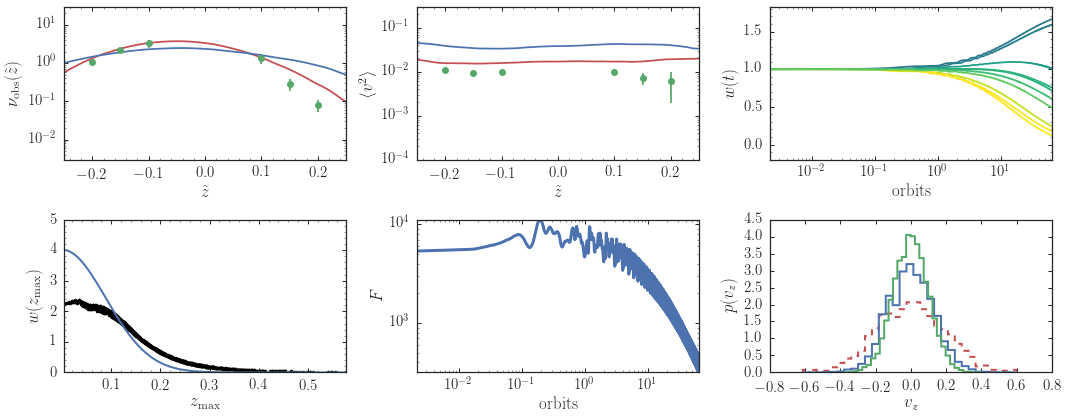

In [20]:
z_m2m= A_m2m*numpy.cos(phi_m2m+nstep*step*omega_m2m)
vz_m2m= -A_m2m*omega_m2m*numpy.sin(phi_m2m+nstep*step*omega_m2m)
z_out= numpy.linspace(-0.3,0.3,101)
dens_final= compute_dens(z_m2m,zsun_true,z_out,h_obs,w_out)
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(15,6)
subplot(2,3,1)
bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[-.25,0.25],yrange=[0.003,30.],gcf=True)
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True)
bovy_plot.bovy_plot(z_out,dens_final,'-',semilogy=True,overplot=True,zorder=0)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
yscale('log',nonposy='clip')
subplot(2,3,2)
v2m_final= compute_v2m(z_m2m,vz_m2m,zsun_true,z_out,h_obs,w_out)
bovy_plot.bovy_plot(z_out,v2m_init,'-',semilogy=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\langle v^2\rangle$',
                   xrange=[-.25,0.25],yrange=[0.0001,.3],gcf=True)
bovy_plot.bovy_plot(z_obs,v2m_obs,'o',semilogy=True,overplot=True)
bovy_plot.bovy_plot(z_out,v2m_final,'-',semilogy=True,overplot=True,zorder=0)
errorbar(z_obs,v2m_obs,yerr=v2m_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
yscale('log',nonposy='clip')
subplot(2,3,3)
for ii in range(len(wevol)):
    bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*omega_true/2./numpy.pi,wevol[ii],'-',
                        color=cm.viridis(A_m2m[windx][ii]/0.3),
                        yrange=[-0.2,numpy.amin([4.,numpy.amax(wevol)*1.1])],
                        semilogx=True,xlabel=r'$\mathrm{orbits}$',ylabel=r'$w(t)$',gcf=True,overplot=ii>0)
subplot(2,3,4)
bovy_plot.bovy_plot(A_m2m,w_out,'k.',xlabel=r'$z_{\mathrm{max}}$',ylabel=r'$w(z_{\mathrm{max}})$',
                   yrange=[0.,5.],gcf=True)
sindx= numpy.argsort(A_m2m)
w_expect= numpy.exp((A_m2m[sindx]*omega_m2m)**2./2.*(1./sigma_init**2.-1./sigma_true**2.))
w_expect/= numpy.sum(w_expect)/len(w_expect)
plot(A_m2m[sindx],w_expect,lw=2.)
subplot(2,3,5)
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*omega_m2m/2./numpy.pi,numpy.sum(Q,axis=1),lw=3.,
                   loglog=True,xlabel=r'$\mathrm{orbits}$',ylabel=r'$F$',gcf=True)
subplot(2,3,6)
_= hist(vz_m2m,weights=w_out,histtype='step',lw=2.,normed=True,bins=31,zorder=1)
_= hist(vz_mock,histtype='step',lw=2.,normed=True,bins=31,zorder=2)
_= hist(vz_m2m,histtype='step',lw=2.,normed=True,bins=31,ls='--',zorder=0)
xlabel(r'$v_z$')
ylabel(r'$p(v_z)$')
print("Velocity dispersions: mock, fit",numpy.std(vz_mock),\
      numpy.sqrt(numpy.sum(w_out*(vz_m2m-numpy.sum(w_out*vz_m2m)/numpy.sum(w_out))**2.)/numpy.sum(w_out)))
tight_layout()

Run without smoothing, both the velocity and density constraints:

In [21]:
step= numpy.pi/3.*10.**-2.
step=0.2
nstep= 10000
eps= 10.**-4.
# x n_m2m, because density is normalised with n
eps_vel= eps*n_m2m
mu= 1.
h_m2m= h_obs
nodens= False
omega_m2m= omega_true
zsun_m2m= zsun_true
z_out= numpy.linspace(-0.3,0.3,101)
v2m_init= compute_v2m(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w_init)
w_out,Q,wevol,windx= run_m2m_weights_wv2m(w_init,A_m2m,phi_m2m,omega_m2m,zsun_m2m,
                                         z_obs,dens_obs,dens_obs_noise,v2m_obs,v2m_obs_noise,
                                         nstep=nstep,step=step,mu=mu,eps=eps,h_m2m=h_m2m,nodens=nodens,
                                         output_wevolution=10,eps_vel=eps_vel)

('Velocity dispersions: mock, fit', 0.099971170801918099, 0.097539539240075884)


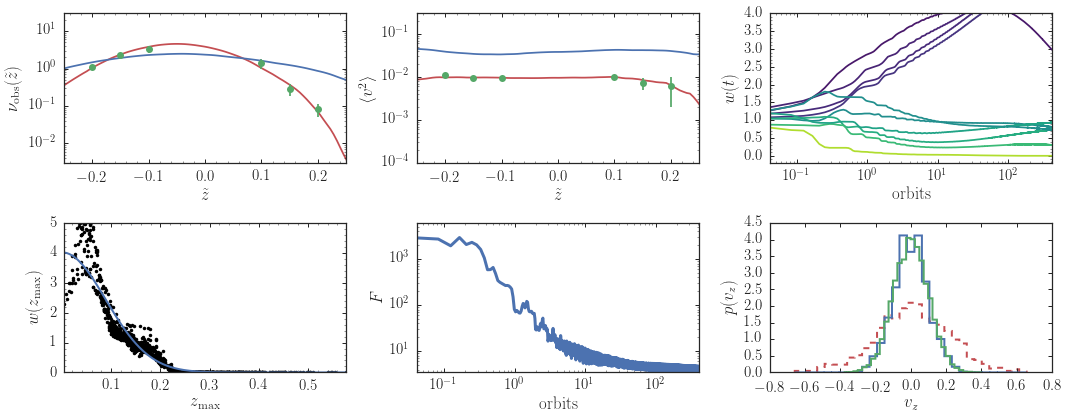

In [22]:
z_m2m= A_m2m*numpy.cos(phi_m2m+nstep*step*omega_m2m)
vz_m2m= -A_m2m*omega_m2m*numpy.sin(phi_m2m+nstep*step*omega_m2m)
z_out= numpy.linspace(-0.3,0.3,101)
dens_final= compute_dens(z_m2m,zsun_true,z_out,h_obs,w_out)
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(15,6)
subplot(2,3,1)
bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[-.25,0.25],yrange=[0.003,30.],gcf=True)
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True)
bovy_plot.bovy_plot(z_out,dens_final,'-',semilogy=True,overplot=True,zorder=0)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
yscale('log',nonposy='clip')
subplot(2,3,2)
v2m_final= compute_v2m(z_m2m,vz_m2m,zsun_true,z_out,h_obs,w_out)
bovy_plot.bovy_plot(z_out,v2m_init,'-',semilogy=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\langle v^2\rangle$',
                   xrange=[-.25,0.25],yrange=[0.0001,.3],gcf=True)
bovy_plot.bovy_plot(z_obs,v2m_obs,'o',semilogy=True,overplot=True)
bovy_plot.bovy_plot(z_out,v2m_final,'-',semilogy=True,overplot=True,zorder=0)
errorbar(z_obs,v2m_obs,yerr=v2m_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
yscale('log',nonposy='clip')
subplot(2,3,3)
for ii in range(len(wevol)):
    bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*omega_true/2./numpy.pi,wevol[ii],'-',
                        color=cm.viridis(A_m2m[windx][ii]/0.3),
                        yrange=[-0.2,numpy.amin([4.,numpy.amax(wevol)*1.1])],
                        semilogx=True,xlabel=r'$\mathrm{orbits}$',ylabel=r'$w(t)$',gcf=True,overplot=ii>0)
subplot(2,3,4)
bovy_plot.bovy_plot(A_m2m,w_out,'k.',xlabel=r'$z_{\mathrm{max}}$',ylabel=r'$w(z_{\mathrm{max}})$',
                   yrange=[0.,5.],gcf=True)
sindx= numpy.argsort(A_m2m)
w_expect= numpy.exp((A_m2m[sindx]*omega_m2m)**2./2.*(1./sigma_init**2.-1./sigma_true**2.))
w_expect/= numpy.sum(w_expect)/len(w_expect)
plot(A_m2m[sindx],w_expect,lw=2.)
subplot(2,3,5)
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*omega_m2m/2./numpy.pi,numpy.sum(Q,axis=1),lw=3.,
                   loglog=True,xlabel=r'$\mathrm{orbits}$',ylabel=r'$F$',gcf=True)
subplot(2,3,6)
_= hist(vz_m2m,weights=w_out,histtype='step',lw=2.,normed=True,bins=31,zorder=1)
_= hist(vz_mock,histtype='step',lw=2.,normed=True,bins=31,zorder=2)
_= hist(vz_m2m,histtype='step',lw=2.,normed=True,bins=31,ls='--',zorder=0)
xlabel(r'$v_z$')
ylabel(r'$p(v_z)$')
print("Velocity dispersions: mock, fit",numpy.std(vz_mock),\
      numpy.sqrt(numpy.sum(w_out*(vz_m2m-numpy.sum(w_out*vz_m2m)/numpy.sum(w_out))**2.)/numpy.sum(w_out)))
tight_layout()

## Also vary $z_\odot$ during the optimization

With velocity constraints. We formulate force of change with the velocity constraints.

In [23]:
step= numpy.pi/3.*10.**-2.
nstep= 10000
eps= 0.01
eps_vel=eps*n_m2m
eps_zo= eps/500.
mu= 10.0
h_m2m= h_obs
omega_m2m= omega_true
zsun_m2m= zsun_true-0.05
(w_out,zsun_out),Q,wevol,windx= run_m2m_weights_zsun_densv2m(w_init,A_m2m,phi_m2m,omega_m2m,zsun_m2m,
                                                     z_obs,dens_obs,dens_obs_noise,v2m_obs,v2m_obs_noise,
                                                     nstep=nstep,step=step,mu=mu,eps=eps,eps_vel=eps_vel,h_m2m=h_m2m,
                                                     eps_zo=eps_zo,output_wevolution=10)

('Velocity dispersions: mock, fit', 0.099971170801918099, 0.097626408367940315)
('Zsun: fit, starting point', 0.049600446026619442, 0.0)


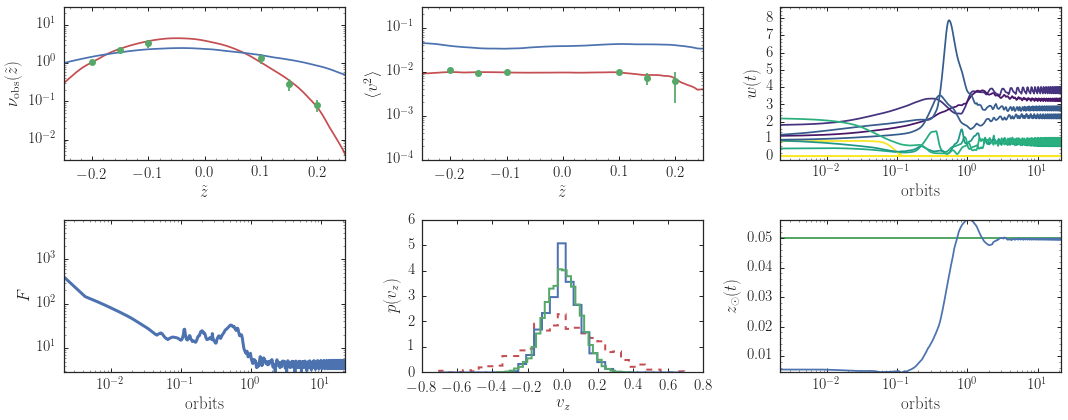

In [24]:
z_m2m= A_m2m*numpy.cos(phi_m2m+nstep*step*omega_m2m)
vz_m2m= -A_m2m*omega_m2m*numpy.sin(phi_m2m+nstep*step*omega_m2m)
z_out= numpy.linspace(-0.3,0.3,101)
dens_final= compute_dens(z_m2m,zsun_out[-1],z_out,h_obs,w_out)
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(15,6)
subplot(2,3,1)
bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[-.25,0.25],yrange=[0.003,30.],gcf=True)
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True)
bovy_plot.bovy_plot(z_out,dens_final,'-',semilogy=True,overplot=True,zorder=0)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
yscale('log',nonposy='clip')
subplot(2,3,2)
v2m_final= compute_v2m(z_m2m,vz_m2m,zsun_true,z_out,h_obs,w_out)
bovy_plot.bovy_plot(z_out,v2m_init,'-',semilogy=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\langle v^2\rangle$',
                   xrange=[-.25,0.25],yrange=[0.0001,.3],gcf=True)
bovy_plot.bovy_plot(z_obs,v2m_obs,'o',semilogy=True,overplot=True)
bovy_plot.bovy_plot(z_out,v2m_final,'-',semilogy=True,overplot=True,zorder=0)
errorbar(z_obs,v2m_obs,yerr=v2m_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
yscale('log',nonposy='clip')
subplot(2,3,3)
for ii in range(len(wevol)):
    bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*omega_true/2./numpy.pi,wevol[ii],'-',
                        color=cm.viridis(A_m2m[windx][ii]/0.3),
                        yrange=[-0.2,numpy.amax(wevol)*1.1],
                        semilogx=True,xlabel=r'$\mathrm{orbits}$',ylabel=r'$w(t)$',gcf=True,overplot=ii>0)
subplot(2,3,4)
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*omega_m2m/2./numpy.pi,numpy.sum(Q,axis=1),lw=3.,
                   loglog=True,xlabel=r'$\mathrm{orbits}$',ylabel=r'$F$',gcf=True)
subplot(2,3,5)
_= hist(vz_m2m,weights=w_out,histtype='step',lw=2.,normed=True,bins=31,zorder=1)
_= hist(vz_mock,histtype='step',lw=2.,normed=True,bins=31,zorder=2)
_= hist(vz_m2m,histtype='step',lw=2.,normed=True,bins=31,ls='--',zorder=0)
xlabel(r'$v_z$')
ylabel(r'$p(v_z)$')
subplot(2,3,6)
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*omega_m2m/2./numpy.pi,zsun_out,'-',
                   xlabel=r'$\mathrm{orbits}$',ylabel=r'$z_\odot(t)$',gcf=True,semilogx=True,zorder=1)
axhline(zsun_true,color=sns.color_palette()[1],lw=2.,zorder=0)
print("Velocity dispersions: mock, fit",numpy.std(vz_mock),\
      numpy.sqrt(numpy.sum(w_out*(vz_m2m-numpy.sum(w_out*vz_m2m)/numpy.sum(w_out))**2.)/numpy.sum(w_out)))
tight_layout()
print("Zsun: fit, starting point",zsun_out[-1],zsun_m2m)

## Also fit for the potential during the optimization

Now we will attempt to simultaneously optimize the potential and the weights using the combined density data. For this, we need to write down the force of change for the potential parameter:

In [25]:
n_m2m= 1000
omega_m2m= omega_true-0.5
sigma_init= 0.2
E_m2m= numpy.random.exponential(scale=sigma_init**2.,size=n_m2m)
phi_m2m_omega= numpy.random.uniform(size=n_m2m)*2.*numpy.pi
A_m2m_omega= numpy.sqrt(2.*E_m2m)/omega_m2m
w_init= numpy.ones(n_m2m)
z_m2m= A_m2m_omega*numpy.cos(phi_m2m_omega)
z_out= numpy.linspace(-0.3,0.3,101)
dens_init= compute_dens(z_m2m,zsun_true,z_out,h_m2m,w_init)
vz_m2m= -omega_m2m*A_m2m_omega*numpy.sin(phi_m2m_omega)
v2m_init= compute_v2m(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w_init)

In [26]:
step= numpy.pi/3.*10.**-2.
step=numpy.pi/20.0
nstep= 10000
eps= 10.**-4.
eps_vel= eps*n_m2m
eps_omega= eps*1.
skipomega= 40
mu= 1.0
h_m2m= 0.1
zsun_m2m= zsun_true
opt_w_first= True
if opt_w_first:
    w_out,Q= run_m2m_weights_wv2m(w_init,A_m2m_omega,phi_m2m_omega,omega_m2m,zsun_m2m,
                                 z_obs,dens_obs,dens_obs_noise,v2m_obs,v2m_obs_noise,
                                 nstep=numpy.amin([nstep,10000]),
                                 step=step,mu=mu,eps=eps,eps_vel=eps_vel,
                                 h_m2m=h_m2m)
else:
    w_out= w_init
if True:
    (w_out,omega_out,z_m2m,vz_m2m),Q= run_m2m_weights_omega_densv2m(w_out,A_m2m_omega,phi_m2m_omega,omega_m2m,zsun_m2m,
                                                        z_obs,dens_obs,dens_obs_noise,v2m_obs,v2m_obs_noise,
                                                        nstep=nstep,step=step,mu=mu,skipomega=skipomega,
                                                        eps=eps,eps_vel=eps_vel,h_m2m=h_m2m,
                                                        eps_omega=eps_omega)

('Velocity dispersions: mock, fit', 0.099971170801918099, 0.096879438000445114)
('omega: fit, starting point', 1.2823450226644275, 0.8)


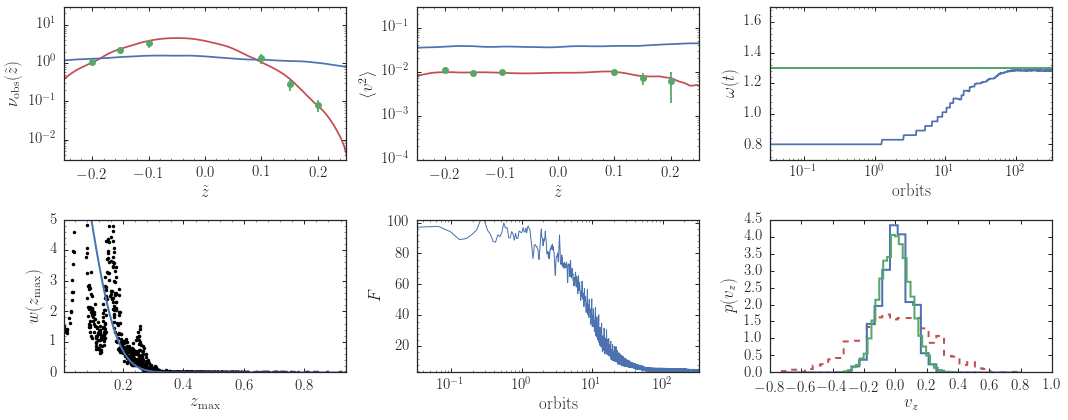

In [27]:
z_out= numpy.linspace(-0.3,0.3,101)
dens_final= compute_dens(z_m2m,zsun_true,z_out,h_obs,w_out)
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(15,6)
subplot(2,3,1)
bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[-.25,0.25],yrange=[0.003,30.],gcf=True)
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True)
bovy_plot.bovy_plot(z_out,dens_final,'-',semilogy=True,overplot=True,zorder=0)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
yscale('log',nonposy='clip')
subplot(2,3,2)
v2m_final= compute_v2m(z_m2m,vz_m2m,zsun_true,z_out,h_obs,w_out)
bovy_plot.bovy_plot(z_out,v2m_init,'-',semilogy=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\langle v^2\rangle$',
                   xrange=[-.25,0.25],yrange=[0.0001,.3],gcf=True)
bovy_plot.bovy_plot(z_obs,v2m_obs,'o',semilogy=True,overplot=True)
bovy_plot.bovy_plot(z_out,v2m_final,'-',semilogy=True,overplot=True,zorder=0)
errorbar(z_obs,v2m_obs,yerr=v2m_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
yscale('log',nonposy='clip')
subplot(2,3,3)
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*numpy.mean(omega_true)/2./numpy.pi,omega_out,'-',
                   xlabel=r'$\mathrm{orbits}$',ylabel=r'$\omega(t)$',gcf=True,semilogx=True,zorder=1,
                   yrange=[omega_m2m/1.3,numpy.amax(omega_out)*1.2])
axhline(omega_true,color=sns.color_palette()[1],lw=2.,zorder=0)
ylim(0.7,1.7)
subplot(2,3,4)
bovy_plot.bovy_plot(A_m2m_omega,w_out,'k.',xlabel=r'$z_{\mathrm{max}}$',ylabel=r'$w(z_{\mathrm{max}})$',
                   yrange=[0.,5.],gcf=True)
sindx= numpy.argsort(A_m2m_omega)
w_expect= numpy.exp((A_m2m_omega[sindx]*omega_true)**2./2.*(1./sigma_init**2.-1./sigma_true**2.))
w_expect/= numpy.sum(w_expect)/len(w_expect)
plot(A_m2m_omega[sindx],w_expect,lw=2.)
subplot(2,3,5)
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*omega_true/2./numpy.pi,numpy.sum(Q,axis=1),lw=1.,
                   semilogx=True,xlabel=r'$\mathrm{orbits}$',ylabel=r'$F$',gcf=True)
subplot(2,3,6)
_= hist(vz_m2m,weights=w_out,histtype='step',lw=2.,normed=True,bins=31,zorder=1)
_= hist(vz_mock,histtype='step',lw=2.,normed=True,bins=31,zorder=2)
_= hist(vz_m2m,histtype='step',lw=2.,normed=True,bins=31,ls='--',zorder=0)
xlabel(r'$v_z$')
ylabel(r'$p(v_z)$')
print("Velocity dispersions: mock, fit",numpy.std(vz_mock),\
      numpy.sqrt(numpy.sum(w_out*(vz_m2m-numpy.sum(w_out*vz_m2m)/numpy.sum(w_out))**2.)/numpy.sum(w_out)))
tight_layout()
print("omega: fit, starting point",numpy.median(omega_out[-1000:-1]),omega_m2m)

Let's compare this to doing the basic M2M fit for different values of $\omega$

In [ ]:
omegas= numpy.linspace(1.1,1.5,11)
step= numpy.pi/3.*10.**-2.
nstep= 10000
eps= 10.**-4.
eps_vel= eps/1.
mu= 10.
h_m2m= 0.1
nodens= False
zsun_m2m= zsun_true
Qs= numpy.zeros_like(omegas)
for ii,omega_m2m in enumerate(omegas):
    w_out,Q= run_m2m_weights_wv2(w_init,A_m2m,phi_m2m,omega_m2m,zsun_m2m,
                                 z_obs,dens_obs,dens_obs_noise,densv2_obs,densv2_obs_noise,
                                 nstep=nstep,step=step,mu=mu,eps=eps,eps_vel=eps_vel,
                                 h_m2m=h_m2m,nodens=nodens)
    Qs[ii]= numpy.sum(numpy.median(Q[-100:-1],axis=0))

In [ ]:
figsize(6,4)
bovy_plot.bovy_plot(omegas,Qs-numpy.amin(Qs),'o-',semilogy=False,
                   xlabel=r'$\omega$',ylabel=r'$\Delta\chi^2(\omega)$')
axvline(omega_true,color=sns.color_palette()[1])
axvline(numpy.median(omega_out[-1000:-1]),color=sns.color_palette()[2])
ylim(-0.3,8.)

What's the answer when we fit a simple DF?

In [ ]:
def lnL_df(p,z_obs,dens_obs,dens_obs_noise,densv2_obs,densv2_obs_noise):
    """p=[omega,sigma]"""
    return -0.5*numpy.sum((numpy.exp(-0.5*(z_obs+zsun_true)**2.*p[0]**2./p[1]**2.)*p[0]/p[1]/numpy.sqrt(2.*numpy.pi)
                                       -dens_obs)**2./dens_obs_noise**2.
                          +(numpy.exp(-0.5*(z_obs+zsun_true)**2.*p[0]**2./p[1]**2.)/numpy.sqrt(2.*numpy.pi)*p[0]*p[1]
                                        -densv2_obs)**2./densv2_obs_noise**2.)
sigmas= numpy.linspace(0.05,0.12,101)
omegas= numpy.linspace(0.8,1.5,101)
lnL= numpy.zeros((len(omegas),len(sigmas)))
for ii,omega in enumerate(omegas):
    for jj,sigma in enumerate(sigmas):
        lnL[ii,jj]= lnL_df([omega,sigma],z_obs,dens_obs,dens_obs_noise,densv2_obs,densv2_obs_noise)

In [ ]:
figsize(6,4)
bovy_plot.bovy_dens2d(-2.*(lnL-numpy.amax(lnL)).T,origin='lower',
                      xrange=[omegas[0],omegas[-1]],
                      yrange=[sigmas[0],sigmas[-1]],
                      xlabel=r'$\omega$',ylabel=r'$\sigma$',
                      zlabel=r'$\Delta\chi^2$',
                      colorbar=True,cmap='viridis',vmax=40.,
                      contours=True,levels=numpy.arange(5)*5.,cntrcolors='w',
                      interpolation='nearest')
axvline(omega_true,color=sns.color_palette()[1])
axvline(numpy.median(omega_out[-1000:-1]),color=sns.color_palette()[2])
print("Best fit: (omega,sigma) = (%.3f,%.3f)"\
          %(omegas[numpy.unravel_index(numpy.argmax(lnL),(len(omegas),len(sigmas)))[0]],
            sigmas[numpy.unravel_index(numpy.argmax(lnL),(len(omegas),len(sigmas)))[1]]))

Thus, the M2M optimization finds the correct value.